In [2]:
pip install -U ipykernel

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Simple print prompt
user_input = input("Enter something: ")
print(f"You entered: {user_input}")

You entered: hej


### Start

pip install sklearn
pip install nltk
pip install seaborn
pip install shap

In [18]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests
import os

from datetime import datetime, timedelta
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import shap


c:\Users\andre\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

In [ ]:

# Load environment variables for API keys
# finnhub api key= cv2ott1r01qqpq6jo0v0cv2ott1r01qqpq6jo0vg
# alpha vantage api key = <R6WUON3CB6JRP1K7>


class MarketSentimentPOC:
    def __init__(self):
        self.finnhub_key = None
        self.alpha_vantage_key = None
        self.news_data = None
        self.price_data = None
        self.labeled_data = None
        self.model = None
        self.vectorizer = None
        self.important_features = None

    def set_keys(self, finnhub_key=None, alpha_vantage_key=None):
        self.finnhub_key = finnhub_key
        self.alpha_vantage_key = alpha_vantage_key
    
    def collect_data(self, tickers, start_date=None, end_date=None, days_back=180):
        """
        Collect historical price and news data for multiple tickers
        """
        if start_date is None:
            start_date = (datetime.now() - timedelta(days=days_back)).strftime('%Y-%m-%d')
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')
            
        print(f"Collecting data from {start_date} to {end_date} for {len(tickers)} tickers")
        
        # Initialize empty dataframes
        self.price_data = pd.DataFrame()
        all_news = []
        
        # Process each ticker
        for ticker in tickers:
            print(f"Processing {ticker}...")
            
            # Get price data
            try:
                stock = yf.Ticker(ticker)
                hist = stock.history(start=start_date, end=end_date)
                hist['ticker'] = ticker
                self.price_data = pd.concat([self.price_data, hist])
                
                # Calculate daily returns
                hist['return'] = hist['Close'].pct_change() * 100
                
                # Get news data for this ticker
                news = self.get_news_for_ticker(ticker, start_date, end_date)
                
                # Add ticker to the news data
                for article in news:
                    article['ticker'] = ticker
                
                all_news.extend(news)
                
                print(f"  - Got {len(news)} news articles and {len(hist)} days of price data")
                
            except Exception as e:
                print(f"  - Error processing {ticker}: {e}")
                continue
        
        # Convert news list to DataFrame
        if all_news:
            self.news_data = pd.DataFrame(all_news)
            print(f"Collected {len(self.news_data)} news articles and {len(self.price_data)} days of price data")
        else:
            print("Failed to collect any news data")
            
    def get_news_for_ticker(self, ticker, start_date, end_date):
        """
        Try to get news from Finnhub first, then Alpha Vantage as backup
        """

        if self.alpha_vantage_key:
            news = self.get_alpha_vantage_news(ticker, start_date, end_date)
            if news and "feed" in news and len(news["feed"]) > 0:
                print(f"  - Using Alpha Vantage news for {ticker}")
                return self.process_alpha_vantage_news(news)

        # Try Finnhub first
        if self.finnhub_key:
            news = self.get_finnhub_news(ticker, start_date, end_date)
            if news and len(news) > 0:
                print(f"  - Using Finnhub news for {ticker}")
                return self.process_finnhub_news(news)
        
        print(f"  - No news found for {ticker}")
        return []
    
    def get_finnhub_news(self, ticker, from_date, to_date):
        """Fetch company news from Finnhub API"""
        from_date = datetime.strptime(from_date, '%Y-%m-%d').strftime('%Y-%m-%d')
        to_date = datetime.strptime(to_date, '%Y-%m-%d').strftime('%Y-%m-%d')    
        url = 'https://finnhub.io/api/v1/company-news'
        params = {
            'symbol': ticker,
            'from': from_date,
            'to': to_date,
            'token': self.finnhub_key
        }
        
        try:
            response = requests.get(url, params=params)
            if response.status_code == 200:
                return response.json()
            else:
                print(f"  - Finnhub API error: {response.status_code}")
                return []
        except Exception as e:
            print(f"  - Error with Finnhub API: {e}")
            return []
        
    def get_alpha_vantage_news(self, ticker, from_date=None, to_date=None):
        """
        Fetch news using Alpha Vantage API
        
        Parameters:
        keywords (str): Search keywords or company name
        from_date (str): Start date in format YYYYMMDD
        to_date (str): End date in format YYYYMMDD
        
        Returns:
        dict: News articles and sentiment information
        """

        if not self.alpha_vantage_key:
            print("Warning: ALPHA_VANTAGE_API_KEY not found in environment variables")
            return {}
        
        url = 'https://www.alphavantage.co/query'
        params = {
            'function': 'NEWS_SENTIMENT',
            'tickers': ticker,
            'apikey': self.alpha_vantage_key,
            'limit': 1000,
            'sort': 'RELEVANCE'
        }
        from_date = datetime.strptime(from_date, '%Y-%m-%d').strftime('%Y%m%dT%H%M')
        to_date = datetime.strptime(to_date, '%Y-%m-%d').strftime('%Y%m%dT%H%M')
        if from_date and to_date:
            params['time_from'] = from_date
            params['time_to'] = to_date
                
        response = requests.get(url, params=params)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error fetching news: {response.status_code}")
            return {}

    
    def process_finnhub_news(self, news_data):
        """Process and standardize Finnhub news data"""
        processed_news = []
        
        for article in news_data:
            if 'datetime' not in article or 'headline' not in article:
                continue
                
            # Convert Unix timestamp to date
            article_date = datetime.fromtimestamp(article['datetime']).strftime('%Y-%m-%d')
            
            processed_news.append({
                'date': article_date,
                'headline': article.get('headline', ''),
                'summary': article.get('summary', ''),
                'source': article.get('source', ''),
                'url': article.get('url', ''),
                'api_source': 'finnhub'
            })
            
        return processed_news
    
    def process_alpha_vantage_news(self, news_data):
        """Process and standardize Alpha Vantage news data"""
        processed_news = []
        
        if "feed" not in news_data:
            return processed_news
            
        for article in news_data["feed"]:
            if 'time_published' not in article or 'title' not in article:
                continue
                
            # Convert time format to date
            try:
                article_date = datetime.strptime(
                    article['time_published'], '%Y%m%dT%H%M%S'
                ).strftime('%Y-%m-%d')
            except:
                continue
                
            # Get sentiment if available
            sentiment_score = None
            if 'overall_sentiment_score' in article:
                try:
                    sentiment_score = float(article['overall_sentiment_score'])
                except:
                    pass
                    
            processed_news.append({
                'date': article_date,
                'headline': article.get('title', ''),
                'summary': article.get('summary', ''),
                'source': article.get('source', ''),
                'url': article.get('url', ''),
                'api_source': 'alpha_vantage',
                'sentiment_score': sentiment_score
            })
            
        return processed_news
    
    def merge_news_with_returns(self, future_days=1):
        """
        Link news articles with subsequent price movements
        """
        if self.news_data is None or self.price_data is None:
            print("No data available for merging")
            return None
            
        # Make a copy of news data for processing
        labeled_news = self.news_data.copy()
        
        # Initialize columns for price movements
        labeled_news['market_move'] = np.nan
        labeled_news['next_day_return'] = np.nan
        labeled_news['future_return'] = np.nan
        
        # Process each news article
        for idx, article in labeled_news.iterrows():
            ticker = article['ticker']
            article_date = article['date']
            
            # Get ticker-specific price data
            ticker_prices = self.price_data[self.price_data['ticker'] == ticker]
            
            ticker_prices['return'] = ((ticker_prices['Open'] - ticker_prices['Close']) / ticker_prices['Close']) * 100

            # Check if there is price data for this date or after
            future_prices = ticker_prices[ticker_prices.index >= article_date]
            
            if len(future_prices) <= future_days:
                continue
                
            # Get the next trading day
            next_trading_day = future_prices.index[0]
            
            # Get price on next trading day
            if next_trading_day in ticker_prices.index:
                next_day_return = ticker_prices.loc[next_trading_day, 'return']
                labeled_news.at[idx, 'next_day_return'] = next_day_return
                
                # Label as positive or negative movement
                if not pd.isna(next_day_return):
                    if next_day_return > 0.5:  # Threshold for positive move
                        labeled_news.at[idx, 'market_move'] = 'positive'
                    elif next_day_return < -0.5:  # Threshold for negative move
                        labeled_news.at[idx, 'market_move'] = 'negative'
                    else:
                        labeled_news.at[idx, 'market_move'] = 'neutral'
            
            # Get return for the future period
            if len(future_prices) > future_days:
                future_trading_day = future_prices.index[future_days]
                if future_trading_day in ticker_prices.index:
                    # Calculate cumulative return over the period
                    start_price = ticker_prices.loc[next_trading_day, 'Close']
                    end_price = ticker_prices.loc[future_trading_day, 'Close']
                    future_return = ((end_price - start_price) / start_price) * 100
                    labeled_news.at[idx, 'future_return'] = future_return
        
        # Drop rows with missing returns
        self.labeled_data = labeled_news.dropna(subset=['future_return'])
        print(f"Created dataset with {len(self.labeled_data)} labeled news articles")
        
        return self.labeled_data
    
    def preprocess_text(self, use_lemmatization=True):
        """
        Preprocess headlines and summaries for NLP
        """
        if self.labeled_data is None or len(self.labeled_data) == 0:
            print("No labeled data available for preprocessing")
            return
            
        # Combine headline and summary
        self.labeled_data['text'] = self.labeled_data['headline'] + ' ' + self.labeled_data['summary'].fillna('')
        
        # Initialize lemmatizer if needed
        lemmatizer = WordNetLemmatizer() if use_lemmatization else None
        
        # Get English stopwords
        stop_words = set(stopwords.words('english'))
        
        # Add financial terms that are too common to be useful
        financial_stopwords = {'stock', 'stocks', 'market', 'markets', 'company', 
                              'share', 'shares', 'price', 'prices', 'investor', 
                              'investors', 'trading', 'trader', 'traders', 'report',
                              'reports', 'reported', 'quarter', 'quarterly', 'fiscal',
                              'financial', 'earnings', 'revenue', 'revenues', 'profit',
                              'profits', 'loss', 'losses'}
        stop_words.update(financial_stopwords)
        
        # Function to clean text
        def clean_text(text):
            if not isinstance(text, str):
                return ""
                
            # Convert to lowercase
            text = text.lower()
            
            # Remove special characters and numbers
            text = re.sub(r'[^\w\s]', ' ', text)
            text = re.sub(r'\d+', ' ', text)
            
            # Tokenize
            tokens = word_tokenize(text)
            
            # Remove stopwords and lemmatize if required
            if use_lemmatization:
                cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
            else:
                cleaned_tokens = [token for token in tokens if token not in stop_words]
                
            # Join tokens back into text
            return ' '.join(cleaned_tokens)
            
        # Apply text cleaning
        print("Preprocessing text data...")
        self.labeled_data['cleaned_text'] = self.labeled_data['text'].apply(clean_text)
        
        # Remove empty texts
        self.labeled_data = self.labeled_data[self.labeled_data['cleaned_text'].str.strip() != '']
        print(f"After preprocessing: {len(self.labeled_data)} articles")
    

    def vectorize_text(self, method='tfidf', max_features=1000, ngram_range=(1, 2)):
        """
        Convert preprocessed text to numerical features, including n-grams.
        """
        if self.labeled_data is None or 'cleaned_text' not in self.labeled_data.columns:
            print("No preprocessed text available for vectorization")
            return None

        print(f"Vectorizing text using {method} method with n-gram range {ngram_range}...")

        # Choose vectorizer
        if method == 'count':
            self.vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
        else:  # default to tfidf
            self.vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)

        # Fit and transform the text data
        X = self.vectorizer.fit_transform(self.labeled_data['cleaned_text'])

        # Get feature names
        feature_names = self.vectorizer.get_feature_names_out()

        # Create DataFrame with features
        X_df = pd.DataFrame(X.toarray(), columns=feature_names)

        print(f"Created {X_df.shape[1]} features from text")
        return X_df
    
    def build_model(self, X_df, target='future_return', test_size=0.2, random_state=42):
        """
        Build and evaluate a model for predicting market movements from text
        """
        if self.labeled_data is None or X_df is None:
            print("No data available for model building")
            return
            
        # Check if target exists in data
        if target not in self.labeled_data.columns:
            print(f"Target column '{target}' not found in data")
            return
            
        print(f"Building model to predict {target}...")
        
        # Get target values
        y = self.labeled_data[target].values
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_df, y, test_size=test_size, random_state=random_state
        )
        self.X_train = X_train
        print(f"Training set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")
        
        # Build models
        models = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=random_state)
        }
        
        results = {}
        
        for name, model in models.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)
            
            # Predict
            y_pred = model.predict(X_test)
            
            # Evaluate
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            print(f"{name} - MSE: {mse:.4f}, R²: {r2:.4f}")
            
            results[name] = {
                'model': model,
                'mse': mse,
                'r2': r2,
                'y_test': y_test,
                'y_pred': y_pred
            }
        
        # Select best model based on R²
        best_model_name = max(results, key=lambda k: results[k]['r2'])
        self.model = results[best_model_name]['model']
        
        print(f"Best model: {best_model_name} with R² = {results[best_model_name]['r2']:.4f}")
        
        # Get feature importance for the best model
        self.extract_important_features(X_df.columns, best_model_name, results[best_model_name]['model'])
        
        return results
    
    def extract_important_features(self, feature_names, model_name, model):
        """
        Extract and visualize important features from the model
        """
        print("Extracting important features...")
        
        if model_name == 'Linear Regression':
            # For linear regression, use coefficients
            importance = np.abs(model.coef_)
            """elif model_name == 'Random Forest':
            # For Random Forest, use feature importance
            importance = model.feature_importances_"""
        elif model_name == 'Random Forest':
            # Use SHAP values
            explainer = shap.Explainer(model, self.X_train)
            shap_values = explainer(self.X_train)
            # Calculate mean absolute SHAP value per feature
            importance = np.abs(shap_values.values).mean(axis=0)
        else:
            print(f"Feature importance extraction not implemented for {model_name}")
            return
            
        # Create a DataFrame with features and importance
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        })
        
        # Sort by importance
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        
        # Save the top features
        self.important_features = feature_importance.head(30)
        
        print("Top 10 most important features:")
        print(self.important_features.head(10))
        
        return self.important_features
    
    def visualize_results(self, results, target='future_return'):
        """
        Create visualizations of model performance and feature importance
        """
        if results is None or self.important_features is None:
            print("No results or feature importance to visualize")
            return
            
        # Set up plot style
        plt.style.use('seaborn-v0_8-darkgrid')
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Plot actual vs predicted values for each model
        for i, (name, result) in enumerate(results.items()):
            ax = axes[0, i]
            ax.scatter(result['y_test'], result['y_pred'], alpha=0.5)
            ax.plot([-10, 10], [-10, 10], 'r--')  # Perfect prediction line
            ax.set_title(f'{name}: Actual vs Predicted {target}')
            ax.set_xlabel('Actual')
            ax.set_ylabel('Predicted')
            ax.text(0.05, 0.95, f"R² = {result['r2']:.4f}\nMSE = {result['mse']:.4f}", 
                   transform=ax.transAxes, fontsize=12, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # 2. Plot top features
        top_n = min(15, len(self.important_features))
        ax = axes[1, 0]
        sns.barplot(x='importance', y='feature', data=self.important_features.head(top_n), ax=ax)
        ax.set_title(f'Top {top_n} Important Features')
        ax.set_xlabel('Importance')
        
        # 3. Plot distribution of target variable
        ax = axes[1, 1]
        sns.histplot(self.labeled_data[target], kde=True, ax=ax)
        ax.set_title(f'Distribution of {target}')
        ax.set_xlabel(target)
        
        plt.tight_layout()
        plt.show()
        
    def create_sentiment_lexicon(self, threshold=0.001):
        """
        Create a market-based sentiment lexicon
        """
        if self.model is None or self.important_features is None:
            print("No model or feature importance available")
            return None
            
        print("Creating market-based sentiment lexicon...")
        
        # Get all coefficients for linear regression
        if isinstance(self.model, LinearRegression):
            # Get all feature names
            all_features = self.vectorizer.get_feature_names_out()
            
            # Get all coefficients
            coefficients = self.model.coef_
            
            # Create sentiment dictionary
            sentiment_dict = {}
            
            for feature, coef in zip(all_features, coefficients):
                # Only include features with significant coefficients
                if abs(coef) > threshold:
                    sentiment = 'positive' if coef > 0 else 'negative'
                    sentiment_dict[feature] = {
                        'sentiment': sentiment,
                        'score': coef
                    }
            
            # Create DataFrame
            lexicon = pd.DataFrame.from_dict(sentiment_dict, orient='index')
            lexicon = lexicon.reset_index().rename(columns={'index': 'word'})
            lexicon = lexicon.sort_values('score', ascending=False)
            
            print(f"Created sentiment lexicon with {len(lexicon)} words")
            
            # Show examples
            print("\nTop positive words:")
            print(lexicon[lexicon['sentiment'] == 'positive'].head(10))
            
            print("\nTop negative words:")
            print(lexicon[lexicon['sentiment'] == 'negative'].tail(10))
            
            return lexicon
        elif isinstance(self.model, RandomForestRegressor):
            # Get all feature names
            all_features = self.vectorizer.get_feature_names_out()
            
            # Use SHAP values
            explainer = shap.Explainer(self.model, self.X_train)
            shap_values = explainer(self.X_train)
            # Calculate mean absolute SHAP value per feature
            coefficients = (shap_values.values).mean(axis=0)
            
            # Create sentiment dictionary
            sentiment_dict = {}
            
            for feature, coef in zip(all_features, coefficients):
                # Only include features with significant coefficients
                if abs(coef) > threshold:
                    sentiment = 'positive' if coef > 0 else 'negative'
                    sentiment_dict[feature] = {
                        'sentiment': sentiment,
                        'score': coef
                    }
            
            # Create DataFrame
            lexicon = pd.DataFrame.from_dict(sentiment_dict, orient='index')
            lexicon = lexicon.reset_index().rename(columns={'index': 'word'})
            lexicon = lexicon.sort_values('score', ascending=False)
            
            print(f"Created sentiment lexicon with {len(lexicon)} words")
            
            # Show examples
            print("\nTop positive words:")
            print(lexicon[lexicon['sentiment'] == 'positive'].head(10))
            
            print("\nTop negative words:")
            print(lexicon[lexicon['sentiment'] == 'negative'].tail(10))
            
            return lexicon
        else:
            print("Sentiment lexicon creation only implemented for Linear Regression")
            return None
    
    def test_shap(self):
        explainer = shap.Explainer(self.model, self.X_train)
        shap_values = explainer(self.X_train)
        return explainer, shap_values
            
    def run_complete_poc(self, tickers, lookback_days=90, future_days=1, 
                        vectorizer_method='tfidf', max_features=1000, ngram_range=(1, 2)):
        """
        Run the complete POC pipeline
        """
        print(f"Starting Market-Based Sentiment Analysis POC with {len(tickers)} tickers")
        
        # 1. Collect data
        self.collect_data(tickers, days_back=lookback_days)
        
        # 2. Merge news with returns
        self.merge_news_with_returns(future_days=future_days)
        
        # 3. Preprocess text
        self.preprocess_text(use_lemmatization=True)
        
        # 4. Vectorize text
        X_df = self.vectorize_text(method=vectorizer_method, max_features=max_features, ngram_range=ngram_range)
        
        # 5. Build model
        results = self.build_model(X_df, target='future_return')
        
        # 6. Visualize results
        self.visualize_results(results)
        shap_explainer, shap_values = self.test_shap()
        # 7. Create sentiment lexicon
        lexicon = self.create_sentiment_lexicon()
        #return shap_explainer, shap_values
        return {
            'labeled_data': self.labeled_data,
            'model': self.model,
            'features': self.important_features,
            'lexicon': lexicon,
            'shap_explainer': shap_explainer,
            'shap_values': shap_values
        }

Starting Market-Based Sentiment Analysis POC with 5 tickers
Processing AAPL...
  - Using Alpha Vantage news for AAPL
  - Got 669 news articles and 249 days of price data
Processing MSFT...
  - Using Alpha Vantage news for MSFT
  - Got 680 news articles and 249 days of price data
Processing GOOG...
  - Using Alpha Vantage news for GOOG
  - Got 667 news articles and 249 days of price data
Processing AMZN...
  - Using Alpha Vantage news for AMZN
  - Got 690 news articles and 249 days of price data
Processing META...
  - Using Alpha Vantage news for META
  - Got 674 news articles and 249 days of price data
Collected 3380 news articles and 1245 days of price data


C:\Users\andre\AppData\Local\Temp\ipykernel_49860\2561392213.py:240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_prices['return'] = ((ticker_prices['Open'] - ticker_prices['Close']) / ticker_prices['Close']) * 100
C:\Users\andre\AppData\Local\Temp\ipykernel_49860\2561392213.py:261: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'negative' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  labeled_news.at[idx, 'market_move'] = 'negative'
C:\Users\andre\AppData\Local\Temp\ipykernel_49860\2561392213.py:240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Created dataset with 2930 labeled news articles
Preprocessing text data...
After preprocessing: 2930 articles
Vectorizing text using tfidf method with n-gram range (1, 2)...
Created 1000 features from text
Building model to predict future_return...
Training set: 2344 samples, Test set: 586 samples
Training Linear Regression...
Linear Regression - MSE: 21.5131, R²: -0.4204
Training Random Forest...
Random Forest - MSE: 13.5341, R²: 0.1064
Best model: Random Forest with R² = 0.1064
Extracting important features...


 99%|===================| 2324/2344 [01:27<00:00]        

Top 10 most important features:
        feature  importance
63        april    0.098272
617      nasdaq    0.059797
885  technology    0.056718
315         etf    0.055135
244        data    0.051603
172       close    0.047063
266     digital    0.043561
513       known    0.043350
877      tariff    0.042612
534     leading    0.041760


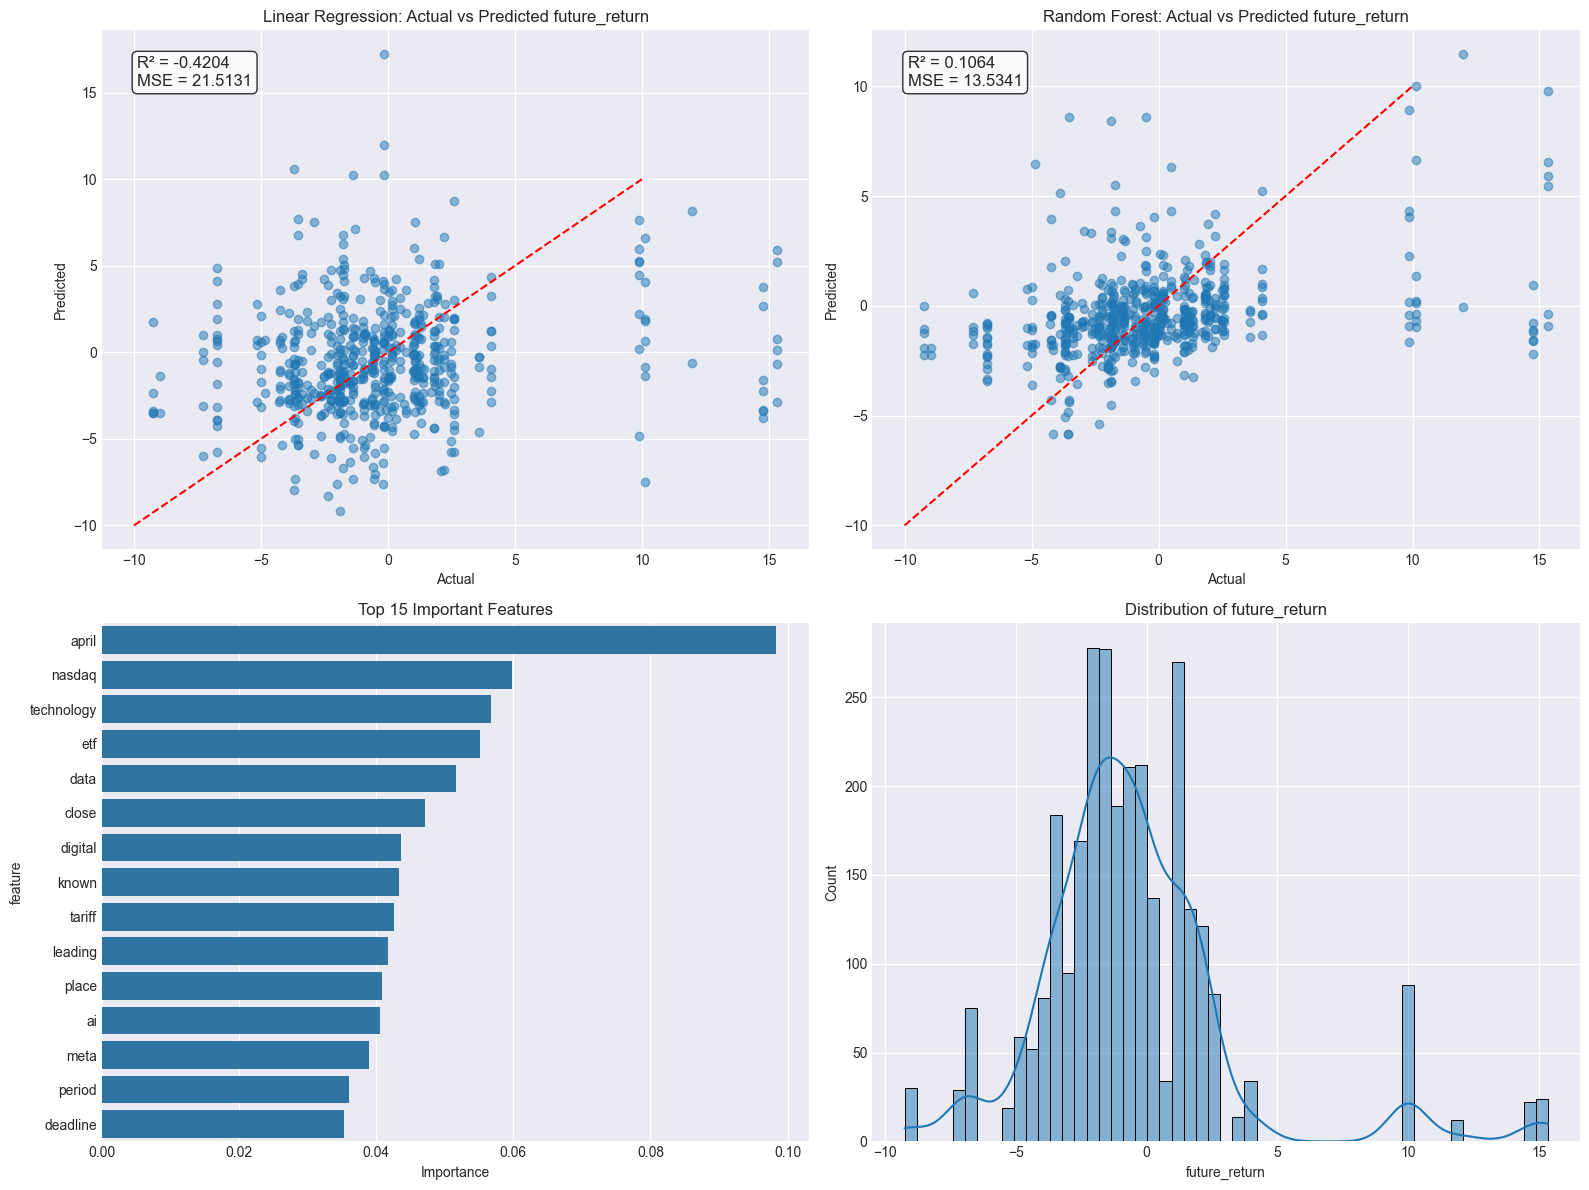

 99%|===================| 2328/2344 [01:24<00:00]        

Creating market-based sentiment lexicon...


100%|===================| 2339/2344 [01:24<00:00]        

Created sentiment lexicon with 384 words

Top positive words:
           word sentiment     score
307   sentiment  positive  0.019182
42    berkshire  positive  0.015201
330     success  positive  0.012147
257      oracle  positive  0.012085
342     tension  positive  0.011967
332    sweeping  positive  0.011930
244        name  positive  0.011180
230        meta  positive  0.010156
354       trade  positive  0.009339
201  investment  positive  0.008949

Top negative words:
          word sentiment     score
147       firm  negative -0.001005
214       like  negative -0.001036
203        key  negative -0.001040
238       move  negative -0.001044
50        bull  negative -0.001046
125  etf right  negative -0.001063
23    approach  negative -0.001075
383       zone  negative -0.001075
297   research  negative -0.001087
370        war  negative -0.001088


In [46]:
if __name__ == "__main__":
    # Define tickers to analyze
    tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META'] # 'MSFT', 'GOOG', 'AMZN', 'META'
    keys = ["cv2ott1r01qqpq6jo0v0cv2ott1r01qqpq6jo0vg", "R6WUON3CB6JRP1K7"] # gmail key: D8GMBK8EBBM99BS4, telia key: NC68XXJ9Z54NFW7O
    # Initialize and run POC
    poc = MarketSentimentPOC()
    poc.set_keys(keys[0], keys[1])
    results = poc.run_complete_poc(tickers, lookback_days=365, future_days=1)
    
    # The results dictionary now contains:
    # - labeled_data: News articles with price movements
    # - model: The best performing model
    # - features: Important features (words) from the model
    # - lexicon: Market-based sentiment lexicon

In [51]:
results["lexicon"][results["lexicon"]["word"] == "april"]

,word,sentiment,score
24,april,negative,-0.009038


In [55]:
results["labeled_data"]["cleaned_text"].iloc[0]

'nvidia next trillion apple microsoft amazon google get first race coveted trillion capitalization nvidia nasdaq nvda apple nasdaq aapl early lead others far behind used afternoon march video published march continue reading'